In [1]:
import tidy3d as td
import numpy as np
import tidy3d.web as web
import scipy.interpolate

# Effective refractive index calculation from tidy3d
def var_eps_eff(point, ref_point, sim, wavelength=1.55, inf=1000):
    """
    To calculate the vertical slab mode at 'point', we will create a 2D slice of the given simulation at
    'point' that extends in the yz plane infinitely, ensuring that it captures the entire permittivity
    profile. Then, to find the 1D mode profile, we use the Tidy3D ModeSolver on a plane at 'point' that
    extends infinitely in the xz plane. This intersection results in the ModeSolver operating on a line
    at 'point' that covers its entire z profile. We then use this to solve for n_eff and M in the above
    formula.
    """
    sim_2d_center = (point[0], point[1], 0) # given a 3D sim, we update the center to create our 2D slice
    sim_2d_size = (0, inf, inf) # we ensure the 2D span of the simulation in the yz plane captures everything
    
    # now we create the 2D simulation, keeping the structures and updating the boundary conditions
    sim_2d = sim.updated_copy(center=sim_2d_center,
                              size=sim_2d_size,
                              sources=[],
                              monitors=[],
                              boundary_spec=sim.boundary_spec.updated_copy(x=td.Boundary.periodic())
                             )
    
    # Now we solve for the mode at 'point':
    # We create the plane in xz that we'll use to examine the mode in z
    mode_solver_plane = td.Box(center=sim_2d.center, size=(td.inf, 0, td.inf))
    # Now we define the mode solver using this plane. We need only solve for one mode here, hence the ModeSpec
    mode_solver = td.plugins.mode.ModeSolver(simulation=sim_2d,
                                             plane=mode_solver_plane,
                                             mode_spec=td.ModeSpec(num_modes=1),
                                             freqs=[td.C_0/wavelength])
    
    # Note that here the mode solving is done locally. For users desiring more accuracy, the remote mode
    # solver should be used.
    mode_data = mode_solver.solve()
    
    # get n_eff from the solver
    n_eff = mode_data.n_eff.item()
    if point == ref_point: return n_eff**2 # if point is the reference point, the integral is 0

    # get z permittivity profile at reference point
    x_ref, y_ref = ref_point
    eps_ref = sim.epsilon(box=td.Box(center=(x_ref, y_ref, list(sim.center)[2]), size=(0,0,td.inf)))
    
    # get z permittivity profile at 'point'
    x, y = point
    eps = sim.epsilon(box=td.Box(center=(x, y, list(sim.center)[2]), size=(0,0,td.inf)))
    
    eps_dif = np.squeeze(eps.values) - np.squeeze(eps_ref.values)

    # get M at the same z coordinates as those of (eps - eps_ref) so we can integrate their product
    z_coords = eps_ref.z.values
    mode_profile = mode_data.Ex
    Mz2 = scipy.interpolate.interp1d(x=mode_profile.z.values, y=np.abs(np.squeeze(mode_profile.values))**2)
    m_values = Mz2(z_coords)

    # calculate integrals
    num, denom = np.trapz(y=eps_dif*m_values, x=z_coords), np.trapz(y=m_values, x=z_coords)
    return n_eff**2 + num/denom

2024-04-20 11:06:40.096 | INFO     | gdsfactory.pdk:activate:309 - 'generic' PDK is now active
2024-04-20 11:06:40.143 | WARNING  | gdsfactory.config:showwarning:296 - Could not connect to klive server. Is klayout open and klive plugin installed?


/home/doan/miniconda3/envs/mp/lib/python3.11/site-packages/gdsfactory/klive.py:49: UserWarning: Could not connect to klive server. Is klayout open and klive plugin installed?
  warnings.warn(


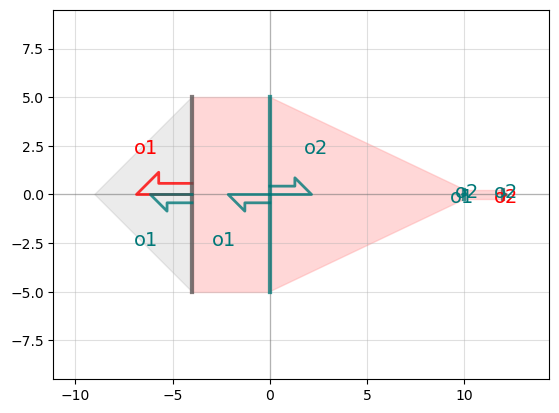

2024-04-20 11:06:40.278 | INFO     | gdsfactory.component:_write_library:2003 - Wrote to 'tapers.gds'
Cell names: tapers, straight_length2_width0p5, taper_width110_width20p5, straight_length4_width10
[<gdstk.Cell object at 0x7b389ad99770>, <gdstk.Cell object at 0x7b389ab46810>, <gdstk.Cell object at 0x7b389ab46630>, <gdstk.Cell object at 0x7b389ab46970>]
Cell 'tapers' with 0 polygons, 0 flexpaths, 0 robustpaths, 3 references, and 0 labels


In [2]:
# Creat gds file using gdsfactory and load it with gdstk for tidy3d
import matplotlib.pyplot as plt
import gdsfactory as gf
import gdstk

@gf.cell
def tapers() -> gf.Component:
    c = gf.Component("tapers")
    t1 = c << gf.components.taper(length=10.0, width1=10, width2=0.5)
    t2 = c << gf.components.straight(width=10, length=4)
    t2.connect(port="o2", destination=t1.ports["o1"])
    t3 = c << gf.components.straight(width=0.5, length=2)
    t3.connect(port="o1", destination=t1.ports["o2"])
    c.add_port("o1", port=t2.ports["o1"])
    c.add_port("o2", port=t3.ports["o2"])
    return c


c = tapers()
gf.remove_from_cache(c)
c.plot()

# c = gf.components.ring_single()
c.write_gds("tapers.gds")

# # Load a GDSII library from the file we just created
lib_loaded = gdstk.read_gds("tapers.gds")

# Create a cell dictionary with all the cells in the file
all_cells = {c.name: c for c in lib_loaded.cells}

print("Cell names: " + ", ".join(all_cells.keys()))

print(lib_loaded.cells)

coup_cell_loaded = all_cells[c.name]

print(coup_cell_loaded)



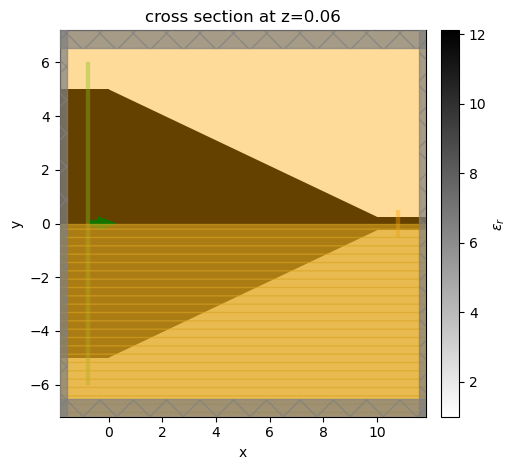

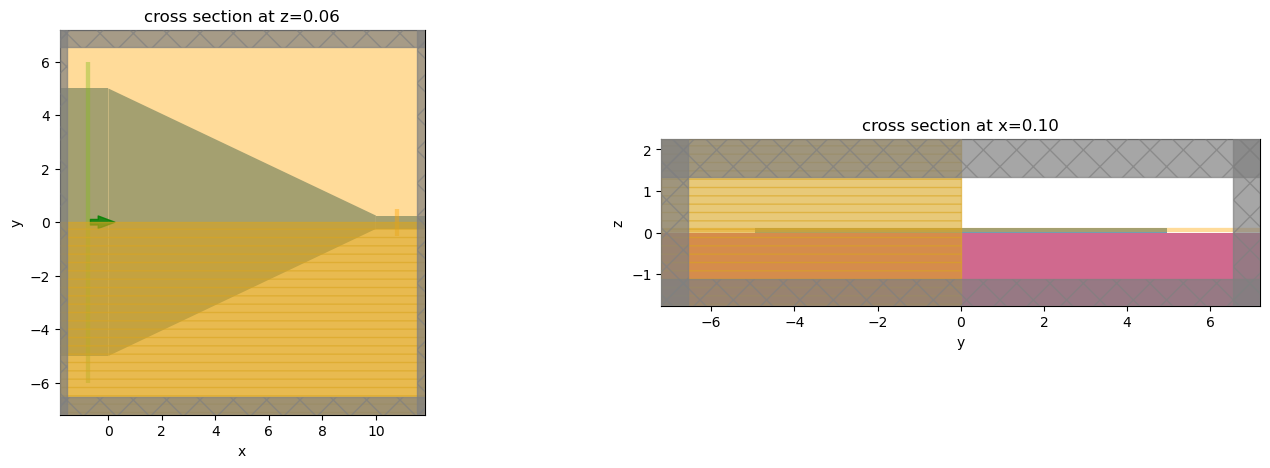

In [3]:
lda0 = 1.55
freq0 = td.C_0 / lda0
ldas = np.linspace(1.5, 1.6, 101)
freqs = td.C_0 / ldas
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))

n_si = 3.48
si = td.Medium(permittivity=n_si**2)
n_sio2 = 1.44
sio2 = td.Medium(permittivity=n_sio2**2)

L_t = 10
w_in = 10  # input waveguied width
w_out = 0.5  # output waveguide width
t_wg = 0.11  # waveguide thickness
inf_eff = 1e3  # effective infinity of the model
# define the substrate structure
sub = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)
    ),
    medium=sio2,
)

tp = td.Geometry.from_gds(
    gds_cell=coup_cell_loaded,
    axis=2,
    slab_bounds=(0, t_wg),
    gds_layer=1,
)

# construct the taper structure using a PolySlab
linear_taper = td.Structure(
    geometry=tp, medium=si,
)

# add a mode source that launches the TE0 mode at the input waveguide
mode_source = td.ModeSource(
    center=(-lda0 / 2, 0, t_wg / 2),
    size=(0, 1.2 * w_in, 6 * t_wg),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
    mode_index=0,
)

# add field monitor to visualize the field distribution at z=t_wg/2
field_monitor = td.FieldMonitor(
    center=(0, 0, t_wg / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# add flux monitor to measure transmission to the output waveguide
flux_monitor = td.FluxMonitor(
    center=(lda0 / 2 + L_t, 0, t_wg / 2),
    size=(0, 2 * w_out, 6 * t_wg),
    freqs=freqs,
    name="flux",
)

# define simulation domain size
Lx = L_t + 2 * lda0
Ly = w_in + 2 * lda0
Lz = t_wg + 1.5 * lda0
sim_size = (Lx, Ly, Lz)

run_time = 3e-12

# define simulation
sim = td.Simulation(
    center=(L_t / 2, 0, t_wg),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[linear_taper, sub],
    sources=[mode_source],
    monitors=[field_monitor, flux_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(
        boundary=td.PML()
    ),
    symmetry=(0, -1, 0),
)

sim.plot_eps(z=t_wg / 2, freq=freq0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))

sim.plot(z=t_wg / 2, edgecolor="k", ax=ax1)
sim.plot(x=0.1, edgecolor="k", ax=ax2)

plt.show()


11:09:31 CEST WARNING: Use the remote mode solver with subpixel averaging for   
              better accuracy through 'tidy3d.plugins.mode.web.run(...)'.       

Output()

11:10:08 CEST WARNING: Did not finish enforcing passivity in dispersion fitter. 
              If the fit is not good enough, consider increasing                
              'AdvancedFastFitterParam.passivity_num_iters'.                    

11:10:10 CEST WARNING: Unable to fit with weighted RMS error under              
              'tolerance_rms' of 1e-05                                          

Output()

11:10:14 CEST WARNING: Unable to fit with weighted RMS error under              
              'tolerance_rms' of 1e-05                                          

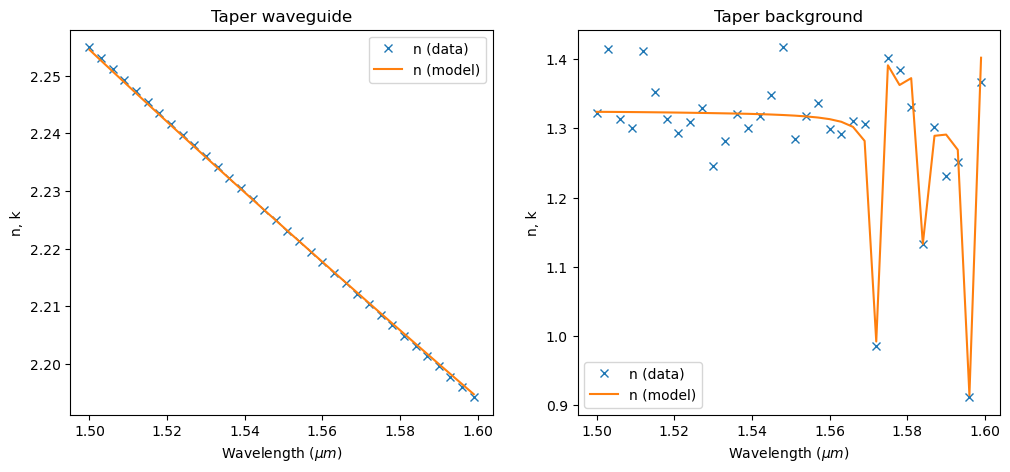

In [4]:
from tidy3d.plugins.dispersion import FastDispersionFitter
# This time we downsample at every third wavelength
step = 3
reference_point = (0,0)
waveguide_eps, background_eps = [], []
for wl in ldas[::step]: # calculate the variational effective permittivity at every third wavelength
    waveguide_eps.append(var_eps_eff((0,0), reference_point, sim, wavelength=wl))
    background_eps.append(var_eps_eff((10,4), reference_point, sim, wavelength=wl))



# again construct the materials fitting these calculated permittivities
waveguide_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(np.real(waveguide_eps)))
background_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(np.real(background_eps)))
waveguide_medium, rms_error = waveguide_fitter.fit()
background_medium, rms_error = background_fitter.fit()

# plot the material fits
fig, ax = plt.subplots(1, 2, figsize=(12,5))
waveguide_fitter.plot(waveguide_medium, ax=ax[0])
background_fitter.plot(background_medium, ax=ax[1])
ax[0].set_title("Taper waveguide")
ax[1].set_title("Taper background")
plt.show()



11:15:19 CEST WARNING: 'geometry=Box(type='Box', center=(0.0, 0.0, -500.0),     
              size=(2000.0, 2000.0, 1000.0)) name=None type='Structure'         
              medium=PoleResidue(name=None, frequency_range=None,               
              allow_gain=False, nonlinear_spec=None, modulation_spec=None,      
              heat_spec=None, type='PoleResidue', eps_inf=1.0,                  
              poles=(((-31341100393127.445-437286024664650.44j),                
              (-20958498582218.945+1101823112809077.5j)),                       
              ((-109249277696072.95-2671685487390061.5j),                       
              (523850044524512.8+4961432367823955j))))' (at                     
              `simulation.structures[1]`) is completely outside of simulation   
              domain.                                                           

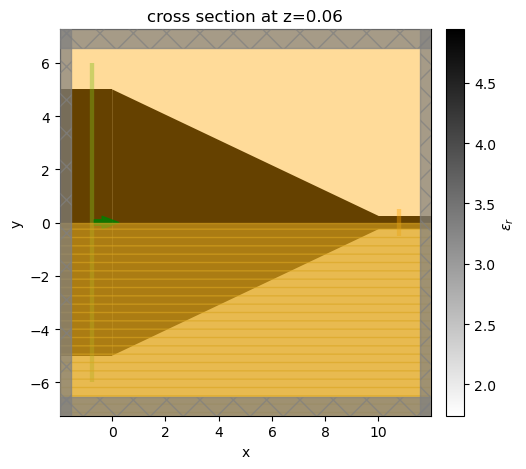

In [5]:
# in the same way as before, update the 3D simulation to a 2D simulation
new_structures = []
for structure in sim.structures:
    new_structures.append(structure.updated_copy(medium=waveguide_medium))

new_center = list(sim.center)
new_center[2] = t_wg / 2

new_size = list(sim.size)
new_size[2] = 0

# Update the symmetry to 2D
new_symmetry = list(sim.symmetry)
new_symmetry[2] = 0

sim2_2d = sim.updated_copy(
    center=new_center,
    size=new_size,
    structures=new_structures,
    boundary_spec=sim.boundary_spec.updated_copy(z=td.Boundary.periodic()),
    medium=background_medium,
    symmetry=new_symmetry
)

sim2_2d.plot_eps(z=t_wg/2, freq=freq0)
plt.show()

In [6]:
sim2_2d_data = web.run(sim2_2d, task_name="var eps 2 2D")

11:21:47 CEST Created task 'var eps 2 2D' with task_id                          
              'fdve-5f9433de-70fe-49e0-b117-9fb06b72e829' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=426881;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f9433de-70fe-49e0-b117-9fb06b72e829\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=867590;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f9433de-70fe-49e0-b117-9fb06b72e829\taskId]8;;\]8;id=426881;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f9433de-70fe-49e0-b117-9fb06b72e829\=]8;;\]8;id=842727;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f9433de-70fe-49e0-b117-9fb06b72e829\fdve]8;;\]8;id=426881;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f9433de-70fe-49e0-b117-9fb06b72e829\-5f9433de-70]8;;\
              ]8;id=426881;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f9433de-70fe-49e0-b117-9fb06b72e829\fe-49e0-b117-9fb06b72e829']8;;\.

Output()

11:21:51 CEST status = queued

Output()

11:21:55 CEST status = preprocess

11:21:59 CEST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

11:22:05 CEST early shutoff detected at 16%, exiting.

              status = postprocess

Output()

11:22:08 CEST status = success

              View simulation result at                                         
              ]8;id=400267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f9433de-70fe-49e0-b117-9fb06b72e829\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=646375;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f9433de-70fe-49e0-b117-9fb06b72e829\taskId]8;;\]8;id=400267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f9433de-70fe-49e0-b117-9fb06b72e829\=]8;;\]8;id=481803;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f9433de-70fe-49e0-b117-9fb06b72e829\fdve]8;;\]8;id=400267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f9433de-70fe-49e0-b117-9fb06b72e829\-5f9433de-70]8;;\
              ]8;id=400267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f9433de-70fe-49e0-b117-9fb06b72e829\fe-49e0-b117-9fb06b72e829']8;;\.

Output()

11:22:19 CEST loading simulation from simulation_data.hdf5

              WARNING: 'geometry=Box(type='Box', center=(0.0, 0.0, -500.0),     
              size=(2000.0, 2000.0, 1000.0)) name=None type='Structure'         
              medium=PoleResidue(name=None, frequency_range=None,               
              allow_gain=False, nonlinear_spec=None, modulation_spec=None,      
              heat_spec=None, type='PoleResidue', eps_inf=1.0,                  
              poles=(((-31341100393127.445-437286024664650.44j),                
              (-20958498582218.945+1101823112809077.5j)),                       
              ((-109249277696072.95-2671685487390061.5j),                       
              (523850044524512.8+4961432367823955j))))' (at                     
              `simulation.structures[1]`) is completely outside of simulation   
              domain.                                                           

<Axes: title={'center': 'cross section at z=0.06'}, xlabel='x', ylabel='y'>

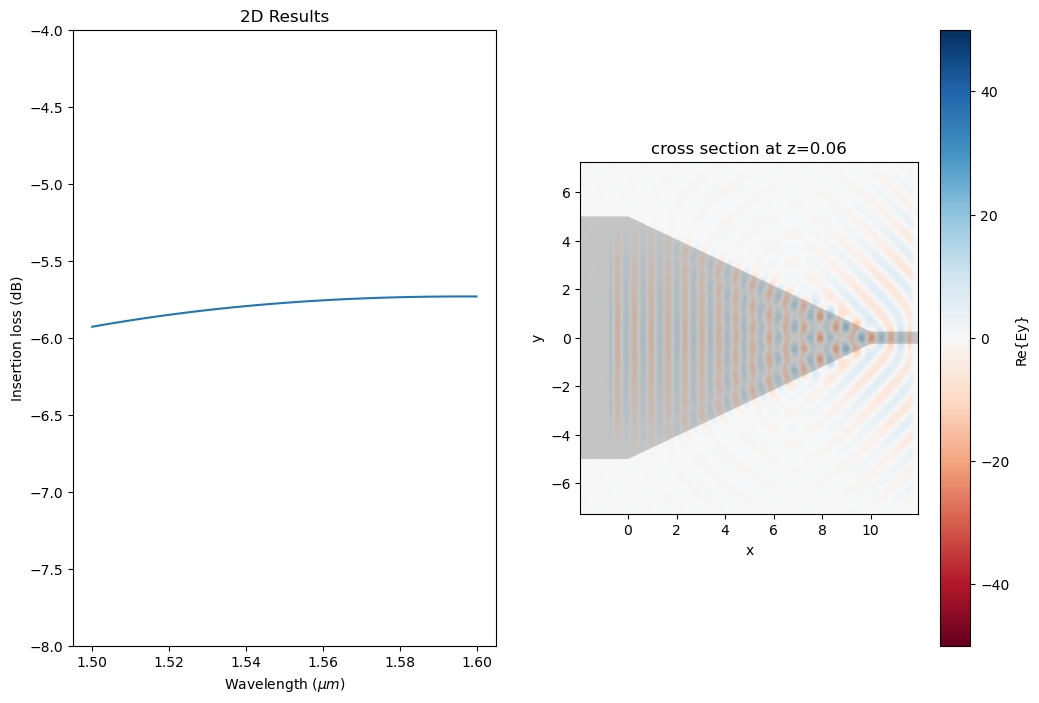

In [11]:
T2_2d = sim2_2d_data["flux"].flux

fig, ax = plt.subplots(1, 2, figsize=(12,8))
ax[0].set_title("2D Results")
ax[0].set_ylim((-8,-4))
ax[0].set_xlabel("Wavelength ($\mu m$)")
ax[0].set_ylabel("Insertion loss (dB)")
ax[0].plot(ldas, 10*np.log10(T2_2d)) # calculate and plot the insertion loss
sim2_2d_data.plot_field(field_monitor_name="field",
                       field_name="Ey",
                       f=freq0,
                       ax=ax[1],
                       vmin=-50,
                       vmax=50)